In [1]:
import glob
import scipy
import os,sys
import zipfile
import numpy as np
import nibabel as nib
import tensorflow as tf
from scipy import ndimage
from tensorflow import keras
from natsort import natsorted
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from aifnet_utils.preprocess import read_nifti_file, normalize, normalize_aif, process_scan, normalize_zero_one
from aifnet_utils.data_loaders import ISLES18DataGen_aif, read_isles_volumepaths_from_file_otf, read_isles_annotations_from_file, ISLES18DataGen_aifvof_otf
from aifnet_utils.data_loaders import delay_sequence_padding, anticipate_sequence_padding, late_bolus, early_bolus
from aifnet_utils.results import plot_predictions
from aifnet_utils.losses import MaxCorrelation
from scipy import signal
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from scipy.linalg import convolution_matrix, toeplitz, circulant
from sklearn.linear_model import Ridge
from matplotlib import pyplot, image, transforms
from scipy import ndimage
from numpy import inf
import matplotlib.patches as patches
import random
keras.backend.set_image_data_format('channels_last')
from aifnet_utils.deconv import build_deconv_A_matrix, build_circular_matrix_implicit, compute_pseudoinverse
from aifnet_utils.deconv import svd_truncated, perform_deconvolution, perform_deconvolution_circular
from aifnet_utils.deconv import plot_cbf_map,plot_estimatedCBF_map,plot_tmax_map, aif_inverse,mask_CBF
from aifnet_utils.deconv import save_nifti_from_array_and_referenceHeader

import time

%matplotlib inline
!pwd

/home/sebastian/experiments/aifnet_replication


In [2]:
#Reading an example PCT volume
LOCATION = 'INSEL'
if LOCATION == 'LOCAL':
    ROOT_EXP = '/Users/sebastianotalora/work/postdoc/ctp/aifnet_replication/'
    root_dir  = '/Users/sebastianotalora/work/postdoc/data/ISLES/'

if LOCATION == 'INSEL':
    ROOT_EXP = '/home/sebastian/experiments/aifnet_replication/'
    root_dir  = '/media/sebastian/data/ASAP/ISLES2018_Training'

if LOCATION == 'SERVER':
    ROOT_EXP = '/home/sotalora/aifnet_replication/'
    root_dir     = '/data/images/sotalora/ISLES18/'

aif_annotations_path = ROOT_EXP + 'radiologist_annotations.csv'
path_cbf_results = '/home/sebastian/experiments/aifnet_replication/results/cbfs/'


In [3]:
min_num_volumes_ctp = 43
current_fold = 1
#Reading AIFs and VOFs for each of the partitions
train_partition_path = ROOT_EXP+'/partitions_cleaned/fold_'+str(current_fold) +'/train_v2.txt'
valid_partition_path = ROOT_EXP+'/partitions_cleaned/fold_'+str(current_fold) +'/valid_v2.txt'
test_partition_path =  ROOT_EXP+'/partitions_cleaned/fold_'+str(current_fold) +'/test_v2.txt'

aif_annotations_train, vof_annotations_train = read_isles_annotations_from_file(aif_annotations_path, train_partition_path, 
                                                root_dir, min_num_volumes_ctp, return_aif_only = False)
aif_annotations_valid, vof_annotations_valid = read_isles_annotations_from_file(aif_annotations_path, valid_partition_path, root_dir, 
                                        min_num_volumes_ctp, return_aif_only = False)
aif_annotations_test, vof_annotations_test = read_isles_annotations_from_file(aif_annotations_path,  test_partition_path,
                                        root_dir, min_num_volumes_ctp, return_aif_only = False)

ctp_volumes_train = read_isles_volumepaths_from_file_otf(root_dir, train_partition_path, aif_annotations_path)
ctp_volumes_valid = read_isles_volumepaths_from_file_otf(root_dir, valid_partition_path, aif_annotations_path)
ctp_volumes_test = read_isles_volumepaths_from_file_otf(root_dir, test_partition_path, aif_annotations_path)

print(len(ctp_volumes_train), len(aif_annotations_train))
print(len(ctp_volumes_valid), len(aif_annotations_valid))
print(len(ctp_volumes_test), len(aif_annotations_test))



107 107
13 13
31 31


In [4]:
ctp_volumes_train

[{'image': '/media/sebastian/data/ASAP/ISLES2018_Training/TESTING/case_3/SMIR.Brain.XX.O.CT_4DPWI.346308/SMIR.Brain.XX.O.CT_4DPWI.346308.nii'},
 {'image': '/media/sebastian/data/ASAP/ISLES2018_Training/TESTING/case_4/SMIR.Brain.XX.O.CT_4DPWI.346316/SMIR.Brain.XX.O.CT_4DPWI.346316.nii'},
 {'image': '/media/sebastian/data/ASAP/ISLES2018_Training/TESTING/case_7/SMIR.Brain.XX.O.CT_4DPWI.346364/SMIR.Brain.XX.O.CT_4DPWI.346364.nii'},
 {'image': '/media/sebastian/data/ASAP/ISLES2018_Training/TESTING/case_8/SMIR.Brain.XX.O.CT_4DPWI.346393/SMIR.Brain.XX.O.CT_4DPWI.346393.nii'},
 {'image': '/media/sebastian/data/ASAP/ISLES2018_Training/TESTING/case_9/SMIR.Brain.XX.O.CT_4DPWI.346402/SMIR.Brain.XX.O.CT_4DPWI.346402.nii'},
 {'image': '/media/sebastian/data/ASAP/ISLES2018_Training/TESTING/case_10/SMIR.Brain.XX.O.CT_4DPWI.346411/SMIR.Brain.XX.O.CT_4DPWI.346411.nii'},
 {'image': '/media/sebastian/data/ASAP/ISLES2018_Training/TESTING/case_11/SMIR.Brain.XX.O.CT_4DPWI.346419/SMIR.Brain.XX.O.CT_4DPWI.3464

In [5]:
aif_annotations_train.keys()

dict_keys(['346308', '346316', '346364', '346393', '346402', '346411', '346419', '346428', '346516', '346541', '346550', '346568', '346576', '346584', '346591', '346626', '346633', '346640', '346647', '346654', '346675', '346682', '346689', '346696', '346717', '346726', '346733', '346740', '346747', '346754', '346761', '346768', '346774', '346781', '346788', '346794', '346801', '346807', '346813', '346819', '345589', '345596', '345617', '345624', '345638', '345645', '345659', '345673', '339335', '339343', '345682', '345689', '345696', '345703', '345710', '345724', '345731', '345738', '345745', '345752', '345759', '345766', '345773', '345780', '345787', '345794', '345801', '345815', '345822', '345829', '345836', '345843', '345850', '345857', '345864', '345871', '345878', '345899', '345906', '345927', '345934', '345941', '345948', '345955', '345962', '345969', '345976', '345983', '346004', '346011', '346018', '346025', '346032', '346039', '346060', '346088', '346095', '346102', '346109',

In [6]:
train_datagen = ISLES18DataGen_aifvof_otf(ctp_volumes=ctp_volumes_train, annotations_aif=aif_annotations_train,
                            annotations_vof = vof_annotations_train,
                            minimum_number_volumes_ctp = min_num_volumes_ctp, batch_size=1,
                                        time_arrival_augmentation = True)
validation_datagen =  ISLES18DataGen_aifvof_otf(ctp_volumes=ctp_volumes_valid, annotations_aif=aif_annotations_valid,
                            annotations_vof = vof_annotations_valid,
                            minimum_number_volumes_ctp = min_num_volumes_ctp, batch_size=1,
                                        time_arrival_augmentation = True)


In [7]:
example_id = 9
sample_pct = train_datagen.__getitem__(example_id)
pct_vals = sample_pct[0][0,:,:,:,:]

aif = sample_pct[1][0].T
vof = sample_pct[1][1].T

In [8]:
path_case = '/'.join(train_datagen.ctp_volumes[example_id]['image'].split('/')[0:-2])
path_cbf = glob.glob(path_case+"/*CBF*/*nii")[0]
path_cbf

'/media/sebastian/data/ASAP/ISLES2018_Training/TESTING/case_23/SMIR.Brain.XX.O.CT_CBF.346544/SMIR.Brain.XX.O.CT_CBF.346544.nii'

Text(0, 0.5, 'Normalized Density (HU)')

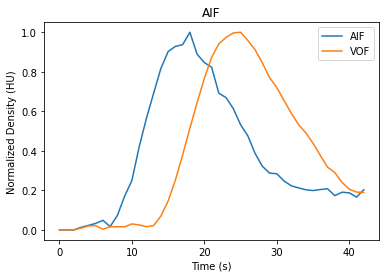

In [9]:
plt.title('AIF')        
#y = normalize_zero_one(aif)
#y_p = normalize_zero_one(vof)
#plt.plot(mu_voi)
#plt.plot(y_p)
plt.plot(aif)
plt.plot(vof)
plt.legend([ 'AIF','VOF'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')


In [10]:
aif

array([0.        , 0.        , 0.        , 0.01329882, 0.02275987,
       0.03290607, 0.04852693, 0.01673692, 0.07328068, 0.17082704,
       0.24982066, 0.4191776 , 0.56368044, 0.69108278, 0.81669312,
       0.90228855, 0.92825394, 0.93722209, 1.        , 0.88889917,
       0.84658941, 0.82303576, 0.69142365, 0.66923292, 0.61323066,
       0.53222242, 0.47580721, 0.38716423, 0.32211755, 0.28737318,
       0.28397704, 0.24754318, 0.22296751, 0.21252973, 0.20306632,
       0.19913538, 0.20432437, 0.20813181, 0.17342869, 0.19078389,
       0.18740505, 0.16598165, 0.2033018 ])

In [11]:
#inverse_aif_circular, S_circ = aif_inverse(circularA, number_of_truncated_values=9,epsilon=0.001)
#CBFs_circular, residue_functions_circular = perform_deconvolution_circular(pct_vals,inverse_aif_circular)

#estimated_cbf = plot_estimatedCBF_map(gt_cbf, CBFs_circular, gt_healty, selected_slice,normalize_healthy_tissue=True)
#plt.imshow(estimated_cbf,cmap=plt.cm.jet, vmax=3.2)

In [16]:
path_results_nibs = ROOT_EXP + '/results/nibs/'
for example_id in range(len(train_datagen))[-20:]:    
    sample_pct = train_datagen.__getitem__(example_id)
    pct_vals = sample_pct[0][0,:,:,:,:]
    num_slices = pct_vals.shape[2]
    deconvolved_cbfs = np.zeros((pct_vals.shape[0],pct_vals.shape[1],pct_vals.shape[2])) #H-W-Slices
    img_path = train_datagen.ctp_volumes[example_id]['image']
    img_fname =img_path.split('/')
    aif = sample_pct[1][0].T
    vof = sample_pct[1][1].T
    #A = build_deconv_A_matrix(aif)
    A = build_circular_matrix_implicit(aif)
    for number_of_trunc_vals in range(6,13):
        for epsi in [0.001,0.0001,0.00001]:
            start_time = time.perf_counter ()
            nib_fname = path_results_nibs + img_fname[-1]+"circ_eigen_"+str(number_of_trunc_vals)+'_eps_'+str(epsi)+'_pred.nii.gz'
            inverse_aif, S = aif_inverse(A,number_of_truncated_values=number_of_trunc_vals,epsilon=epsi)                
            #CBFs, residue_functions = perform_deconvolution(pct_vals,inverse_aif)
            CBFs, residue_functions = perform_deconvolution_circular(pct_vals,inverse_aif)
            for selected_slice in range(num_slices):
                gt_cbf = plot_cbf_map(train_datagen, selected_slice,example_id, return_array_only=True)
                gt_healty = plot_tmax_map(train_datagen, selected_slice,example_id,return_array_only=True)                                
                masked_CBF_slice = mask_CBF(gt_cbf, CBFs, selected_slice)
                deconvolved_cbfs[:,:,selected_slice] = masked_CBF_slice            
            save_nifti_from_array_and_referenceHeader(deconvolved_cbfs, img_path, nib_fname)
            end_time = time.perf_counter ()
            print(end_time - start_time, " seconds to process " + nib_fname.split('/')[-1])

SyntaxError: invalid syntax (<ipython-input-16-06973b23eea9>, line 14)

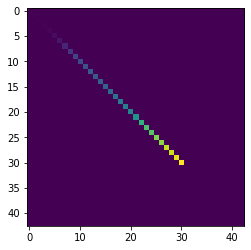

In [20]:
plt.imshow(S)

In [13]:
# Create figure and axes
location_residue_1 = (170,130)
location_residue_2 = (90,150)
plt.plot(residue_functions_circular[location_residue_1[0],location_residue_1[1],selected_slice,:])
plt.plot(residue_functions_circular[location_residue_2[0],location_residue_2[1],selected_slice,:])

fig, ax = plt.subplots()

# Display the image
ax.imshow(estimated_cbf,cmap=plt.cm.jet, vmax=2.9)

# Create a Rectangle patch
rect1 = patches.Rectangle((location_residue_1[0], location_residue_1[1]), 10, 10, linewidth=5, edgecolor='r', facecolor='none')
rect2 = patches.Rectangle((location_residue_2[0], location_residue_2[1]), 10, 10, linewidth=5, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect1)
ax.add_patch(rect2)

plt.show()

NameError: name 'residue_functions_circular' is not defined